# Fine-Tuning GPT for Personalized Recipe Recommendation and Generating Visualizations with GANs

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer


## 1. Data Preprocessing and Analysis

Dataset link: [Food.com - Recipes and Reviews](https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews)

### Loading the Datasets

In [7]:
# Load the datasets
recipes_df = pd.read_csv('Datasets/recipes.csv')
reviews_df = pd.read_csv('Datasets/reviews.csv')

### Exploratory Data Analysis (EDA)

In [8]:
# Basic Information
print("Recipes Dataframe:")
print(recipes_df.info())
print("\nReviews Dataframe:")
print(reviews_df.info())

Recipes Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 


In [9]:
# Quick look at the data
recipes_df.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [10]:
# Quick look at the data
reviews_df.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [11]:
print("Missing values in Recipes Dataset:")
missing_values_recipes = recipes_df.isnull().sum()
print(missing_values_recipes[missing_values_recipes > 0])

print("\nMissing values in Reviews Dataset:")
missing_values_reviews = reviews_df.isnull().sum()
print(missing_values_reviews[missing_values_reviews > 0])

Missing values in Recipes Dataset:
CookTime                       82545
Description                        5
Images                             1
RecipeCategory                   751
Keywords                       17237
RecipeIngredientQuantities         3
AggregatedRating              253223
ReviewCount                   247489
RecipeServings                182911
RecipeYield                   348071
dtype: int64

Missing values in Reviews Dataset:
Review    214
dtype: int64


### Data Cleaning

In [12]:
# Parsing Time Duration Strings
def parse_duration(duration_str):
    
    if pd.isnull(duration_str):
        return None  
    hours = minutes = 0
    hours_match = re.search(r'(\d+)H', duration_str)
    minutes_match = re.search(r'(\d+)M', duration_str)
    if hours_match:
        hours = int(hours_match.group(1))
    if minutes_match:
        minutes = int(minutes_match.group(1))

    return hours * 60 + minutes

In [13]:
def parsing_values(values_str):
    
    if pd.notna(values_str):
        values_str = values_str.replace('c(', '(')
        # Remove non-alphanumeric characters except commas, spaces, and '&'
        values_str = re.sub(r'[^\w\s,&]', '', values_str)
        # Remove brackets and quotes
        values_str = re.sub(r'[\[\]\'\"]', '', values_str)

    return values_str

In [14]:
def parsing_imageURL(values_imageURL):

    if pd.isna(values_imageURL) or values_imageURL is None:
        return []
    if values_imageURL.strip() == 'character(0)':
        return []
    urls = re.findall(r'https?://[^\s"]+', values_imageURL)

    image_urls_mod = [url.rstrip('",') for url in urls]

    return image_urls_mod

In [15]:
recipes_df['CookTimeMin'] = recipes_df['CookTime'].apply(parse_duration)
recipes_df['PrepTimeMin'] = recipes_df['PrepTime'].apply(parse_duration)
recipes_df['TotalTimeMin'] = recipes_df['TotalTime'].apply(parse_duration)
recipes_df['Images'] = recipes_df['Images'].apply(parsing_imageURL)
recipes_df['Keywords'] = recipes_df['Keywords'].apply(parsing_values)
recipes_df['RecipeInstructions'] = recipes_df['RecipeInstructions'].apply(parsing_values)

recipes_df.drop(['CookTime', 'PrepTime', 'TotalTime'], axis=1, inplace=True)

In [16]:
# Recipes Dataset Handling

# Impute 'CookTime' with median (or mean, based on your preference)
cook_time_median = recipes_df['CookTimeMin'].median()
recipes_df['CookTimeMin'].fillna(cook_time_median, inplace=True)

# Drop NA for 'Description' and 'Keywords' columns
recipes_df.dropna(subset=['Description', 'Keywords'], inplace=True)

# Assign 'Other' to missing 'RecipeCategory'
recipes_df['RecipeCategory'].fillna('Other', inplace=True)

# Drop NA for 'Images' and 'RecipeIngredientQuantities' columns
recipes_df.dropna(subset=['Images', 'RecipeIngredientQuantities'], inplace=True)

recipes_df['AggregatedRating'].fillna(recipes_df['AggregatedRating'].median(), inplace=True)
recipes_df['ReviewCount'].fillna(0, inplace=True)

# 'RecipeServings' and 'RecipeYield' set to median and placeholder value
recipes_df['RecipeServings'].fillna(recipes_df['RecipeServings'].median(), inplace=True)
recipes_df['RecipeYield'].fillna('Varies', inplace=True)

# Reviews Dataset Handling

# Drop NA reviews
reviews_df.dropna(subset=['Review'], inplace=True)

# Removing Duplicates
recipes_df.drop_duplicates(subset=['RecipeId'], keep='first', inplace=True)
reviews_df.drop_duplicates(subset=['ReviewId'], keep='first', inplace=True)


In [17]:
# Check for missing values after data cleaning
print("Updated missing values for Recipes Dataset:")
updated_missing_values_recipes = recipes_df.dropna().isnull().sum()
if updated_missing_values_recipes.any():
    print(updated_missing_values_recipes[updated_missing_values_recipes > 0])
else:
    print("No missing values found! ^_^")

print("\nUpdated missing values for Reviews Dataset:")
updated_missing_values_reviews = reviews_df.dropna().isnull().sum()
if updated_missing_values_reviews.any():
    print(updated_missing_values_reviews[updated_missing_values_reviews > 0])
else:
    print("No missing values found! ^_^")

Updated missing values for Recipes Dataset:
No missing values found! ^_^

Updated missing values for Reviews Dataset:
No missing values found! ^_^


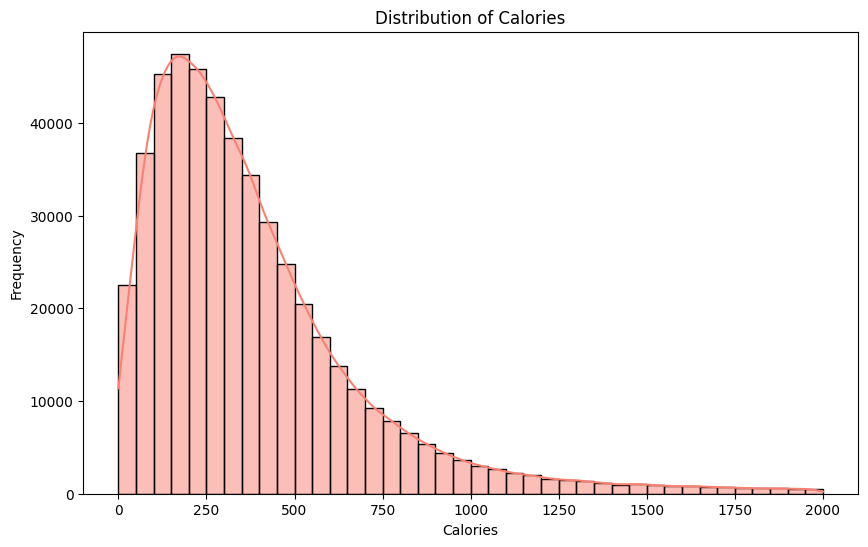

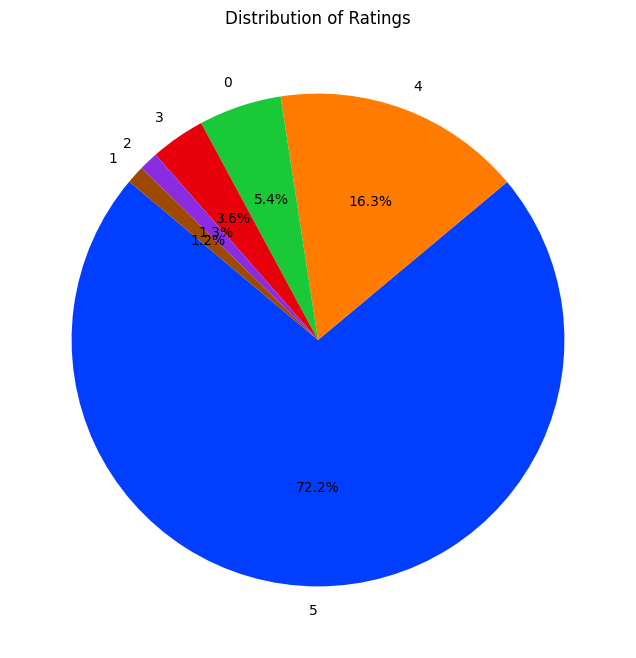

In [18]:
# Set the color palette
palette_color = sns.color_palette('bright')
sns.set_palette(palette_color)

# Nutritional content (Calories) visualization
plt.figure(figsize=(10, 6))
sns.histplot(recipes_df['Calories'][recipes_df['Calories'] < 2000], bins=40, kde=True, color='salmon')
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

# Count the occurrences of each rating
ratings_count = reviews_df['Rating'].value_counts()

# Generate a colorful pie chart for the ratings distribution
plt.figure(figsize=(8, 8))
plt.pie(ratings_count, labels=ratings_count.index, autopct='%1.1f%%', startangle=140, colors=palette_color)
plt.title('Distribution of Ratings')
plt.show()

### Feature Engineering

In [19]:
# Difficulty level based on TotalTime
recipes_df['DifficultyLevel'] = pd.cut(recipes_df['TotalTimeMin'], 
                                       bins=[0, 60, 120, 180, float('inf')], 
                                       labels=['Easy', 'Medium', 'Hard', 'Very Hard'])

# Healthiness score based on nutritional content
recipes_df['HealthScore'] = (recipes_df['ProteinContent'] - recipes_df['FatContent']) / recipes_df['Calories']

In [20]:
# Merge the two dataframes on RecipeId to include Rating column in recipes_df
recipes_df = pd.merge(recipes_df, reviews_df[['RecipeId', 'Rating']], on='RecipeId', how='left')

In [21]:
# Display updated DataFrame
recipes_df.head()

,RecipeId,Name,AuthorId,AuthorName,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,...,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,CookTimeMin,PrepTimeMin,TotalTimeMin,DifficultyLevel,HealthScore,Rating
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,[https://img.sndimg.com/food/image/upload/w_55...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","c(""4"", ""1/4"", ""1"", ""1"")",...,3.2,4.0,Varies,"Toss 2 cups berries with sugar, Let stand for ...",1440.0,45,1485,Very Hard,0.004096,5.0
1,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,[https://img.sndimg.com/food/image/upload/w_55...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","c(""4"", ""1/4"", ""1"", ""1"")",...,3.2,4.0,Varies,"Toss 2 cups berries with sugar, Let stand for ...",1440.0,45,1485,Very Hard,0.004096,4.0
2,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,[https://img.sndimg.com/food/image/upload/w_55...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","c(""4"", ""1/4"", ""1"", ""1"")",...,3.2,4.0,Varies,"Toss 2 cups berries with sugar, Let stand for ...",1440.0,45,1485,Very Hard,0.004096,4.0
3,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,[https://img.sndimg.com/food/image/upload/w_55...,Frozen Desserts,"Dessert, Low Protein, Low Cholesterol, Healthy...","c(""4"", ""1/4"", ""1"", ""1"")",...,3.2,4.0,Varies,"Toss 2 cups berries with sugar, Let stand for ...",1440.0,45,1485,Very Hard,0.004096,4.0
4,39,Biryani,1567,elly9812,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,[https://img.sndimg.com/food/image/upload/w_55...,Chicken Breast,"Chicken Thigh & Leg, Chicken, Poultry, Meat, A...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...",...,63.4,6.0,Varies,Soak saffron in warm milk for 5 minutes and pu...,25.0,240,265,Very Hard,0.004142,3.0


In [22]:
# Select relevant columns
relevant_columns = ['Name', 'Description', 'Keywords',
                    'RecipeInstructions', 'DifficultyLevel', 'HealthScore', 'Images', 'Rating']
recipes_df = recipes_df[relevant_columns]

# 'Name', 'Description', 'Keywords', and 'RecipeInstructions' are the relevant columns for text preprocessing.
# 'RecipeCategory', 'Rating', 'DifficultyLevel', and 'HealthScore' doesn't contain textual information as they are
# numerical or categorical features, so we won't include it for text preprocessing.

# Text preprocessing
recipes_df['Name'] = recipes_df['Name'].str.lower()
recipes_df['Description'] = recipes_df['Description'].str.lower()
recipes_df['Keywords'] = recipes_df['Keywords'].str.lower()
recipes_df['RecipeInstructions'] = recipes_df['RecipeInstructions'].str.lower()
recipes_df['DifficultyLevel'] = recipes_df['DifficultyLevel'].str.lower()

# Format each image URL in the Prompt-Response Format and store in a new column
formatted_images_data = [
    f"Prompt {i+1}: Response: {link}" for i, link in enumerate(recipes_df['Images'])]
# Create a new column for the formatted image URLs
recipes_df['FormattedImages'] = formatted_images_data

# Main text data to be fed into transformer model
recipes_df['text_data'] = recipes_df.apply(
    lambda x: f"<name> {x['Name']}\n<description> {x['Description']}\n<keywords> {x['Keywords']}\n<instructions> {x['RecipeInstructions']}\n<difficulty> {x['DifficultyLevel']}\n<health> {x['HealthScore']}\n<rating> {x['Rating']}\n<images> {x['FormattedImages']}", axis=1)


In [23]:
# Sample a portion of data
sampled_df = recipes_df.sample(frac=0.0015625, random_state=42)

In [24]:
sampled_df.to_csv('Datasets/processedRecipes.csv', index=False)

In [25]:
processed_text_data = sampled_df['text_data'].tolist()

In [26]:
# Save processed text data into a text file
with open('Datasets/processed_recipes.txt', 'w', encoding='utf-8') as file:
    for text in processed_text_data:
        file.write(text + '\n')

# References

1. https://pandas.pydata.org/docs/
1. https://numpy.org/doc/
1. https://matplotlib.org/stable/index.html
1. https://seaborn.pydata.org/
1. https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/